# Problema Abordado

## **Image-to-Text: Geração Automática de Legendas para Imagens**

O problema de **image-to-text**, ou geração de legendas para imagens, consiste em transformar automaticamente uma imagem em uma descrição textual que represente seu conteúdo de forma clara e informativa.

### Por que essa tarefa é relevante?

- **Conexão entre visão e linguagem:** Traduzir imagens em texto é um passo crucial para permitir que máquinas compreendam e comuniquem informações visuais, integrando visão computacional e processamento de linguagem natural.

- **Melhora na acessibilidade:** Usuários com deficiência visual podem se beneficiar de descrições automáticas que transmitam o que está presente nas imagens.

- **Facilita a busca e organização:** Sistemas de recuperação de imagens podem utilizar legendas para indexação, melhorando a precisão na busca por conteúdo visual.

- **Base para aplicações avançadas:** Assistentes virtuais, robôs autônomos e sistemas de vigilância podem utilizar legendas geradas automaticamente para interpretar cenas em tempo real.

### Desafios principais

- Compreender o conteúdo visual de forma contextualizada, incluindo objetos, ações e relações.

- Gerar texto natural, coerente e relevante à imagem.

- Integrar efetivamente informações visuais e linguísticas, que possuem representações muito diferentes.

### Nossa abordagem

Este projeto usa um modelo híbrido: um **encoder baseado em redes convolucionais** para extrair características visuais detalhadas e um **decoder GPT-2**, pré-treinado em grandes corpora textuais, para gerar legendas condicionadas à imagem. Essa combinação visa unir a capacidade de representação visual profunda com o poder da geração de linguagem natural.

---

A geração automática de descrições para imagens é um campo em rápido crescimento, com grande potencial para impactar diversas áreas da inteligência artificial e aplicações do cotidiano.


# Implementação

## Importações

In [163]:
import torch
from torchvision import transforms, datasets
from torchvision import models
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from datasets import load_dataset
from PIL import Image
import os
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split
import time


## Funções Auxiliares

In [184]:
def train_validate_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()

    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        start_time = time.time()

        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0

        for batch in train_loader:
            images = batch["image_tensor"].to(device)
            captions = batch["tokenized_caption"].to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images, captions[:, :-1])  # input tokens
            logits = outputs[:, 1:, :]                 # remove predição do prefixo imagem
            targets = captions[:, 1:]                  # tokens a serem previstos

            # Loss
            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1)
            )

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Acurácia por token (ignora padding)
            predictions = logits.argmax(dim=-1)        # shape: (B, T)
            mask = targets != 50256                    # 50256 = <eos>, usado como padding
            correct = ((predictions == targets) & mask).sum().item()
            total = mask.sum().item()

            epoch_correct += correct
            epoch_total += total

        # Fim da época
        acc = epoch_correct / epoch_total if epoch_total > 0 else 0.0
        avg_loss = epoch_loss / len(train_loader)
        avg_test_loss = evaluate_model(model, test_loader, device, criterion)
        train_losses.append(avg_loss)
        test_losses.append(avg_test_loss)
        elapsed = time.time() - start_time

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f} - Test Loss: {avg_test_loss:.4f} - Acc: {acc:.4f} - Time: {elapsed:.2f}s")

    return train_losses, test_losses


In [165]:
def evaluate_model(model, test_loader, device, criterion):
    model.eval()
    total_loss = 0.0

    
    with torch.no_grad():
        for batch in test_loader:
            images = batch["image_tensor"].to(device)
            captions = batch["tokenized_caption"].to(device)

            outputs = model(images, captions[:, :-1])
            logits = outputs[:, 1:, :]                 
            targets = captions[:, 1:]
            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1)
            )

            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)

    
    
    return avg_loss

In [166]:
#Função para ajustar dimensões dos tensores do dataset

def collate_fn(batch):
    # Extrai cada campo do batch
    images = [item["image_tensor"] for item in batch]
    captions = [item["caption"] for item in batch]
    input_ids = [item["tokenized_caption"] for item in batch]
    attention_masks = [item["attention_mask"] for item in batch]
    images_orig = [item["image_original"] for item in batch]

    # Empilha as imagens (todas já têm o mesmo shape, então stack direto)
    image_tensor = torch.stack(images)

    # Faz padding nas sequências de texto
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=50256)  # eos_token_id para GPT-2
    attention_mask_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    return {
        "image_tensor": image_tensor,                    # (B, 3, 224, 224)
        "caption": captions,                             # Lista de strings
        "tokenized_caption": input_ids_padded,           # (B, T)
        "attention_mask": attention_mask_padded,         # (B, T)
        "image_original": images_orig                    # Lista de PIL Images
    }


In [167]:
def generate_caption(model, image_tensor, tokenizer, max_length=30, device="cuda"):
    model.eval()

    with torch.no_grad():
        # Extrai vetor da imagem
        image_tensor = image_tensor.unsqueeze(0).to(device)  # shape: (1, 3, 224, 224)
        image_features = model.encoder(image_tensor)         # (1, 256)
        img_embed = model.decoder.image_proj(image_features).unsqueeze(1)  # (1, 1, 768)

        # Começa com token vazio
        input_ids = torch.tensor([[tokenizer.bos_token_id or tokenizer.eos_token_id]], device=device)

        # Lista de embeddings: começa com imagem
        generated = img_embed

        for _ in range(max_length):
            # Embedding do texto gerado até agora
            text_embeds = model.decoder.gpt.transformer.wte(input_ids)
            gpt_input = torch.cat([img_embed, text_embeds], dim=1)

            attention_mask = torch.ones(gpt_input.shape[:2], device=device)

            outputs = model.decoder.gpt(inputs_embeds=gpt_input, attention_mask=attention_mask)
            next_token_logits = outputs.logits[:, -1, :]  # último token
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

            if next_token.item() == tokenizer.eos_token_id:
                break

            input_ids = torch.cat([input_ids, next_token], dim=-1)

        caption = tokenizer.decode(input_ids[0], skip_special_tokens=True)
        return caption

In [168]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(15, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Conjunto de Dados: DeepFashion

O conjunto de dados utilizado para o treinamento do modelo foi o **DeepFashion**, uma base amplamente utilizada em tarefas de **Image to Text**.

### Visão Geral

- **Tamanho**: Cerca de **9.000 imagens**
- **Formato das imagens**: RGB, com alta variedade de poses, planos e fundos
---
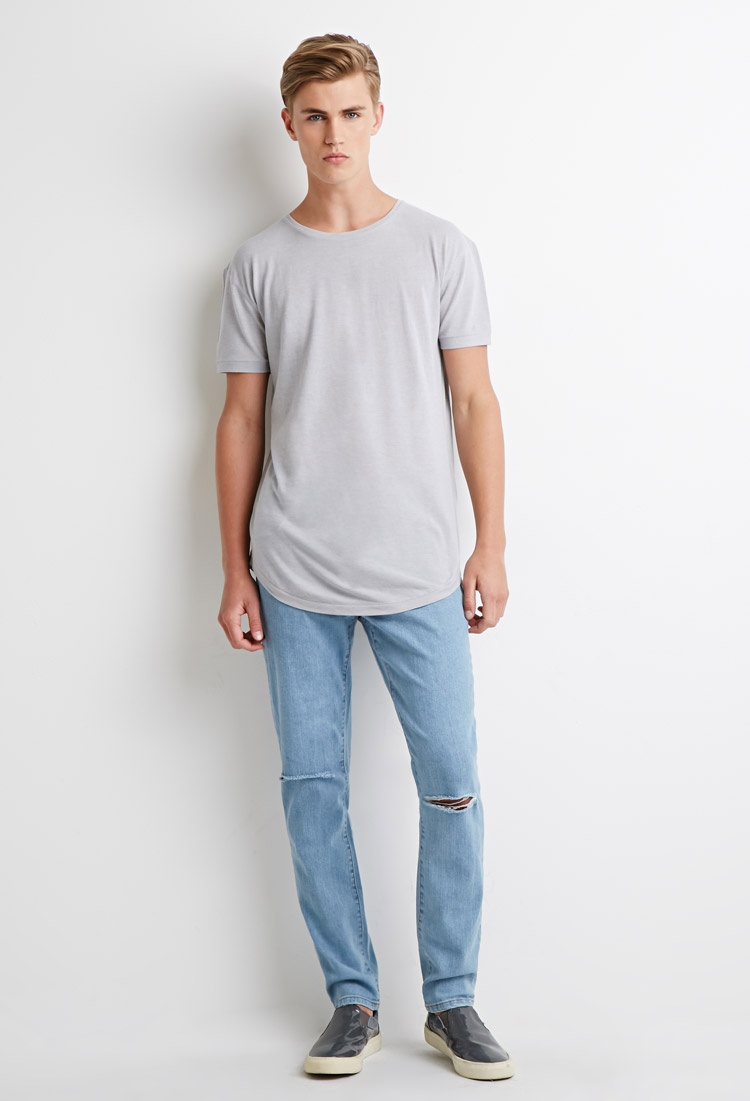                 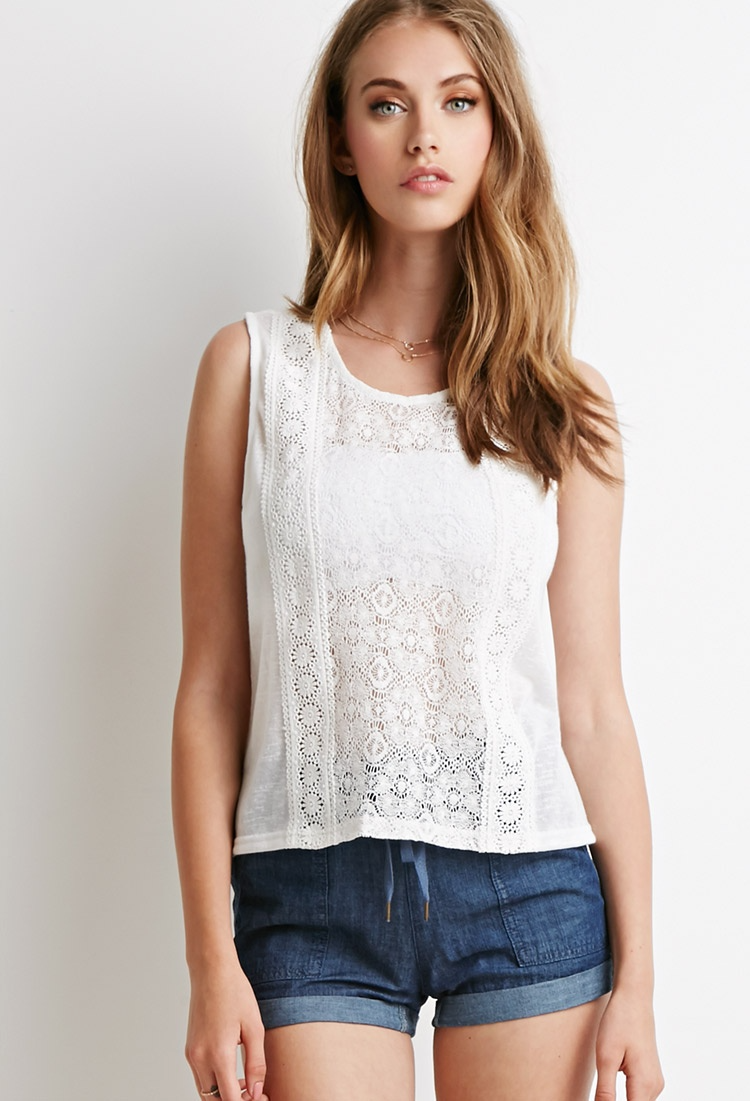
---
### Subconjunto Utilizado

Para o problema de **Image to Text**, foi utilizado o subconjunto com **descrições curtas de roupas**. Cada exemplo consiste em:

- **Entrada**: imagem de uma peça de roupa
- **Saída**: legenda textual que descreve a peça


---

### Pré-processamento

As seguintes etapas de pré-processamento foram realizadas:

- **Redimensionamento das imagens** para um tamanho fixo (por exemplo, `224x224` pixels), necessário para o encoder convolucional.
- **Normalização** dos pixels com média e desvio padrão de `ImageNet`, garantindo compatibilidade com redes pré-treinadas.
- **Tokenização dos textos** com o tokenizer do GPT-2 (subword), transformando legendas em tensores numéricos compatíveis com o decoder.

---

### Data Augmentation

Foram utilizadas técnicas leves de *data augmentation* durante o treinamento para aumentar a variabilidade e reduzir o overfitting:

- **Flip horizontal aleatório**
- **Crop e resize aleatório**
- **Jitter de brilho/contraste**

#### Benefícios:

- Ajuda o modelo a **generalizar** para diferentes poses e iluminações
- Melhora o desempenho em imagens reais fora do dataset

---

### Conclusão

O DeepFashion oferece um excelente ponto de partida para modelos de **Image To Text**, por sua variedade e riqueza visual. A combinação de imagens realistas e descrições textuais curtas permite o treinamento de modelos robustos para geração de legendas com compreensão semântica de roupas e moda.


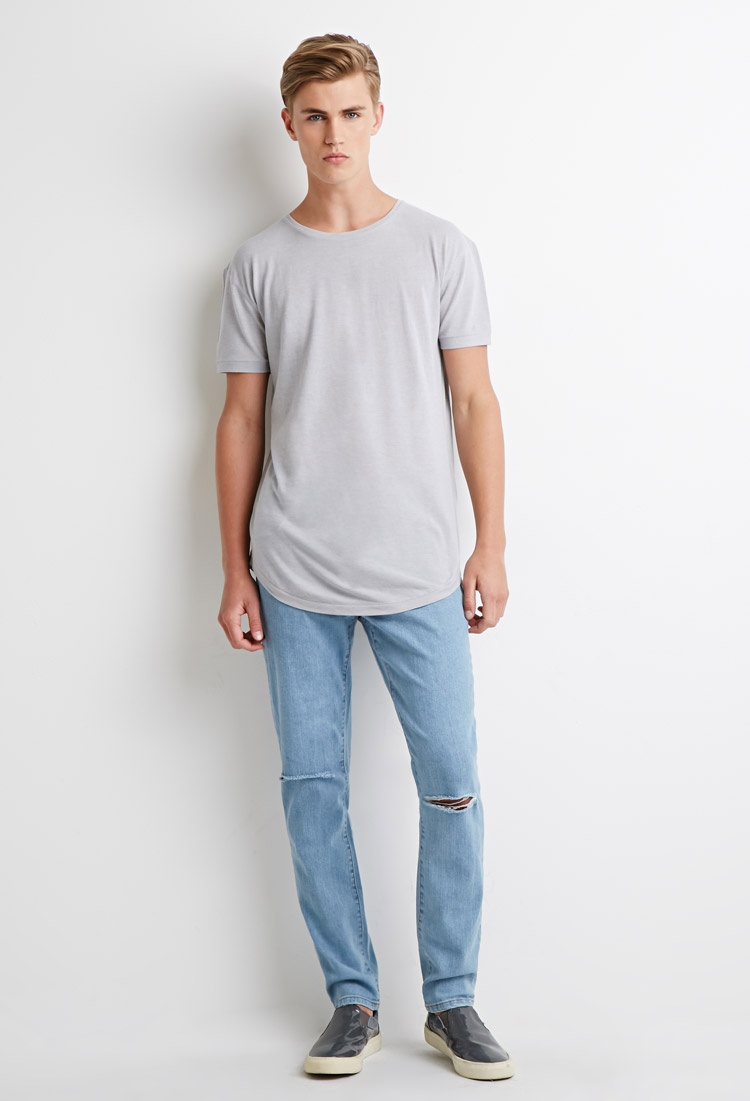

### Carregando o dataset


In [169]:


class DeepFashionDataset(Dataset):
    def __init__(self, labelDataset, image_dir, transform=None, tokenizer=None):
        self.df = labelDataset.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

        # Tokenizador padrão: GPT-2
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.tokenizer.pad_token = self.tokenizer.eos_token  # GPT-2 não tem pad_token original

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        caption = row["caption"]
        img_path = os.path.join(self.image_dir, row["path"].replace("\\", "/"))
        img_path = os.path.normpath(img_path)
        # Imagem original e transformada
        image_pil = Image.open(img_path).convert("RGB")
        image_tensor = self.transform(image_pil) if self.transform else image_pil

        # Tokenização (sem truncamento, padding tratado no collate_fn no Dataloader)
        tokens = self.tokenizer(caption, return_tensors="pt")
        input_ids = tokens["input_ids"].squeeze(0)
        attention_mask = tokens["attention_mask"].squeeze(0)

        return {
            "image_tensor": image_tensor,
            "caption": caption,
            "tokenized_caption": input_ids,
            "attention_mask": attention_mask,
            "image_original": image_pil
        }





train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                 # Redimensiona para 224x224
    transforms.RandomHorizontalFlip(p=0.5),        # Flip horizontal com 50% de chance
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop aleatório e resize para 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Ajusta brilho e contraste
    transforms.ToTensor(),                          # Converte PIL Image para tensor [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],        # Normalização ImageNet
                         std=[0.229, 0.224, 0.225])
])

In [170]:
labels_df = pd.read_csv('/kaggle/input/deep-fashion-datasets/labels_front.csv')
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12278 entries, 0 to 12277
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      12278 non-null  object
 1   caption       12278 non-null  object
 2   path          12278 non-null  object
 3   gender        12278 non-null  object
 4   product_type  12278 non-null  object
 5   product_id    12278 non-null  object
 6   image_type    12278 non-null  object
dtypes: object(7)
memory usage: 671.6+ KB


In [171]:
labels_df['image_id'].head()
labels_df["image_id"] = labels_df["image_id"].str.replace(r"\.jpg$", "", regex=True) + ".jpg"


In [172]:
# Filtrar o DataFrame mantendo apenas image_ids que estão presentes na pasta
images_dir = "/kaggle/input/deep-fashion-datasets/selected_images/selected_images"
available_images = set(os.listdir(images_dir))
labels_df = labels_df[labels_df["image_id"].isin(available_images)].reset_index(drop=True)
labels_df = labels_df.sample(n=3000, random_state=42).reset_index(drop=True)


### Data Loader

In [173]:
dataset = DeepFashionDataset(
    labelDataset = labels_df,
    image_dir = "/kaggle/input/deep-fashion-datasets/selected_images/selected_images",
    transform = transform
)


In [174]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


batch_size = 16 #Quantos exemplos são processsados juntos durante o treino
#Como não estamos truncando o tamanho dos tokens precisamos garantir que todas as legendas
# tenham o mesmo tamanho de tensor o collate_fn ajustara esse tamanho com

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

## Rede Implementada

## Arquitetura do Encoder

A classe `Encoder` implementa uma rede neural convolucional profunda que extrai características de imagens RGB (3 canais) e projeta essas características em um espaço vetorial de dimensão fixa (`output_dim`, padrão: 256). Essa arquitetura é útil para tarefas de extração de embeddings ou como backbone em modelos maiores.

### Estrutura da Rede

A rede é composta por quatro blocos convolucionais seguidos por uma camada de projeção totalmente conectada:

#### Blocos Convolucionais

Cada bloco contém:

- Uma camada `Conv2d` com `kernel_size=3`, `stride=1` e `padding=1` para preservar a resolução espacial.
- Normalização em lote (`BatchNorm2d`) para estabilizar o treinamento.
- Função de ativação `ReLU` para não-linearidade.
- `MaxPool2d(2, 2)` para reduzir a resolução espacial pela metade.

Resumo dos blocos:

| Bloco | Entrada              | Saída                | Operações                                                        |
|-------|----------------------|-----------------------|------------------------------------------------------------------|
| 1     | 3 × 224 × 224        | 32 × 112 × 112        | Conv2d → BatchNorm → ReLU → MaxPool2d(2, 2)                      |
| 2     | 32 × 112 × 112       | 64 × 56 × 56          | Conv2d → BatchNorm → ReLU → MaxPool2d(2, 2)                      |
| 3     | 64 × 56 × 56         | 128 × 28 × 28         | Conv2d → BatchNorm → ReLU → MaxPool2d(2, 2)                      |
| 4     | 128 × 28 × 28        | 256 × 1 × 1           | Conv2d → BatchNorm → ReLU → AdaptiveAvgPool2d(1 × 1)             |

#### Camada de Projeção

Após os blocos convolucionais:

- O tensor 4D de saída (batch_size, 256, 1, 1) é achatado (`view`) para um vetor de dimensão 256.
- Passa por uma `Linear(256, output_dim)` para projeção no espaço de embedding final.

### Diagrama de Fluxo

```text
Input (3xHxW)
   ↓
[Conv2d → BatchNorm → ReLU → MaxPool] × 4
   ↓
AdaptiveAvgPool2d (1x1)
   ↓
Flatten
   ↓
Linear (256 → output_dim)
   ↓
Output: Tensor (batch_size, output_dim)


In [175]:
class Encoder(nn.Module):
    def __init__(self, output_dim=256):
        super().__init__()

        # Camadas convolucionais
        self.features = nn.Sequential(
            # Bloco 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Bloco 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Bloco 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Bloco 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Projeção para a dimensão desejada
        self.projection = nn.Linear(256, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.projection(x)
        return x



## Arquitetura do Decoder: `Gpt2Decoder`

A classe `Gpt2Decoder` implementa um decodificador baseado no modelo pré-treinado **GPT-2**, modificado para receber **características visuais** como prefixo de entrada textual. Esse módulo é ideal para tarefas de geração de texto condicionada à imagem, como **image captioning** ou **visual storytelling**.

### Estrutura da Rede

O `Gpt2Decoder` realiza os seguintes passos:

1. **Carregamento do GPT-2**:
   - Utiliza o modelo `GPT2LMHeadModel` da biblioteca Hugging Face.
   - Todos os pesos do GPT-2 são congelados, exceto:
     - As **últimas 4 camadas do transformador** (`h[-4:]`).
     - A **cabeça de linguagem** (`lm_head`), responsável pela predição dos tokens.

2. **Projeção das Características Visuais**:
   - Um `Linear(image_dim, n_embd)` projeta o vetor de características da imagem (`image_features`) para o espaço de embeddings do GPT-2.

3. **Token Embedding**:
   - Os `textTokens` (tokens de entrada) são convertidos em embeddings por meio da tabela `wte` do GPT-2.

4. **Concatenação**:
   - O embedding da imagem (1 vetor) é **concatenado** na frente da sequência de embeddings do texto.
   - Isso permite que a imagem seja interpretada como um *token prefixo* pelo modelo.

5. **Máscara de Atenção**:
   - Uma máscara binária é construída:
     - `1` para tokens válidos e o prefixo (imagem).
     - `0` para o token especial de padding (`50256`).

6. **Decodificação com GPT-2**:
   - O modelo recebe os embeddings concatenados e a máscara de atenção.
   - A saída são os **logits** preditivos para os próximos tokens na sequência.

### Diagrama de Fluxo

```text
image_features (B, image_dim)
   ↓
Linear → (B, n_embd)
   ↓
Unsqueeze → (B, 1, n_embd)
   ↓
GPT-2 token embeddings (B, T, n_embd)
   ↓
Concat [image_embed | text_embed] → (B, T+1, n_embd)
   ↓
Attention mask [1 | mask(text)] → (B, T+1)
   ↓
GPT-2 Transformer
   ↓
Output logits (B, T+1, vocab_size)


In [176]:
class Gpt2Decoder(nn.Module):
    def __init__(self, image_dim=256):
        super().__init__()
        self.gpt = GPT2LMHeadModel.from_pretrained("gpt2")


        for param in self.gpt.parameters():
            param.requires_grad = False

        for param in self.gpt.transformer.h[-4:].parameters():
            param.requires_grad = True
        for param in self.gpt.lm_head.parameters():
            param.requires_grad = True

        self.image_proj = nn.Linear(image_dim, self.gpt.config.n_embd)

    def forward(self, textTokens, image_features):
        batch_size = textTokens.size(0)


        img_embed = self.image_proj(image_features).unsqueeze(1)


        text_embeds = self.gpt.transformer.wte(textTokens)

        gpt_input = torch.cat([img_embed, text_embeds], dim=1)

        attention_mask = (textTokens != 50256).float()
        prefix_mask = torch.ones(batch_size, 1, dtype=attention_mask.dtype,
                               device=attention_mask.device)
        full_attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)

        outputs = self.gpt(inputs_embeds=gpt_input, attention_mask=full_attention_mask)
        return outputs.logits


## Modelo Final: `ImageCaptionModel`

A classe `ImageCaptionModel` implementa um modelo completo de **captionamento de imagens** combinando um **encoder convolucional** para extrair características visuais e um **decoder baseado no GPT-2** para gerar descrições em linguagem natural.

### Arquitetura Geral

O modelo é dividido em dois componentes principais:

1. **Encoder (CNN)**: Extrai um vetor de características compactas da imagem.
2. **Decoder (GPT-2)**: Gera uma legenda textual condicionada à imagem.




In [177]:
class ImageCaptionModel(nn.Module):
    def __init__(self, encoder_output_dim=256):
        super().__init__()
        self.encoder = Encoder(output_dim=encoder_output_dim)

        self.decoder = Gpt2Decoder(image_dim=encoder_output_dim)

    def forward(self, images, captions):
        image_features = self.encoder(images)
        logits = self.decoder(captions, image_features)
        return logits

# Função de Perda e Otimizador no Treinamento de Modelos de Captionamento de Imagens

Neste projeto, utilizamos um modelo de captionamento de imagens que combina uma rede convolucional como encoder e o GPT-2 como decoder. O processo de treinamento requer escolhas cuidadosas da função de perda e do otimizador, que devem ser compatíveis com a natureza sequencial e multimodal do problema. Abaixo, detalhamos as escolhas feitas e justificamos seu uso.

## Função de Perda: `CrossEntropyLoss`

A tarefa de captionamento de imagem é, essencialmente, um problema de **modelagem de linguagem condicional**: dado um vetor de características da imagem, o modelo deve prever a sequência de palavras que descreve essa imagem.

Para isso, utilizamos a função de perda `nn.CrossEntropyLoss`, que é apropriada para tarefas de **classificação de próximo token**. Em cada passo da geração, o modelo produz uma distribuição de probabilidade sobre o vocabulário, e a perda mede o quão distante essa distribuição está do próximo token verdadeiro da legenda.

```python
criterion = nn.CrossEntropyLoss(ignore_index=50256)
```

### Justificativas:

* É a escolha padrão para modelos de linguagem como o GPT-2.
* Permite o cálculo da perda token a token, agregando o erro ao longo da sequência.
* O parâmetro `ignore_index=50256` evita penalizar o modelo por prever o token de padding (`<|endoftext|>` do GPT-2), o que é importante para lidar com legendas de comprimentos variáveis.

Essa função de perda assegura que o modelo aprenda a gerar sequências linguisticamente coerentes e semanticamente alinhadas com o conteúdo da imagem.

---

## Otimizador: `Adam`

O otimizador adotado foi o **Adam** (`torch.optim.Adam`), que combina as vantagens da descida de gradiente com momento e adaptação de taxa de aprendizado.

```python
optimizer = optim.Adam(model.parameters(), lr=1e-4)
```

### Justificativas:

* O Adam é eficaz para redes profundas, pois ajusta individualmente a taxa de aprendizado de cada parâmetro.
* A combinação de momentum e normalização por segundo momento é especialmente útil para estabilizar o treinamento de modelos grandes como o GPT-2.
* A taxa de aprendizado `1e-4` é moderada, apropriada para **fine-tuning** de modelos pré-treinados, como é o caso aqui.

Ademais, como o modelo congela parte do GPT-2 (exceto as últimas camadas e a lm\_head), o otimizador atuará principalmente sobre:

* O encoder convolucional, que é treinado do zero.
* As últimas camadas do decoder, que serão ajustadas para integrar eficientemente a informação visual ao texto gerado.

---

## Conclusão

A combinação de `CrossEntropyLoss` com `Adam` forma uma base sólida e bem estabelecida para o treinamento de modelos de linguagem natural condicionados por imagem. Enquanto a perda guia o modelo a produzir sequências coerentes, o otimizador garante uma atualização estável e eficiente dos pesos.

Essas escolhas estão alinhadas com boas práticas da literatura recente em vision-language modeling e são adequadas para obter bons resultados em tarefas como image captioning.


In [179]:
device = torch.device("cuda")
model = ImageCaptionModel().to(device)


criterion = nn.CrossEntropyLoss(ignore_index=50256)  # Ignora padding tokens
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Treinamento da Rede

In [185]:

train_losses, test_losses = train_validate_model(model, train_loader, criterion, optimizer, device, epochs=3)


Epoch 1/3 - Train Loss: 0.4205 - Test Loss: 0.3893 - Acc: 0.8256 - Time: 69.15s
Epoch 2/3 - Train Loss: 0.3603 - Test Loss: 0.3761 - Acc: 0.8424 - Time: 66.86s
Epoch 3/3 - Train Loss: 0.3489 - Test Loss: 0.3677 - Acc: 0.8467 - Time: 66.31s


In [154]:

#torch.save(model.state_dict(), "modelo_treinado.pth")


In [190]:
train_losses, test_losses

([0.4205288728981307, 0.36028957999113836, 0.34886431445678073],
 [0.3893488269103201, 0.37607110226363466, 0.36773470200990377])

# Qualidade dos Resultados

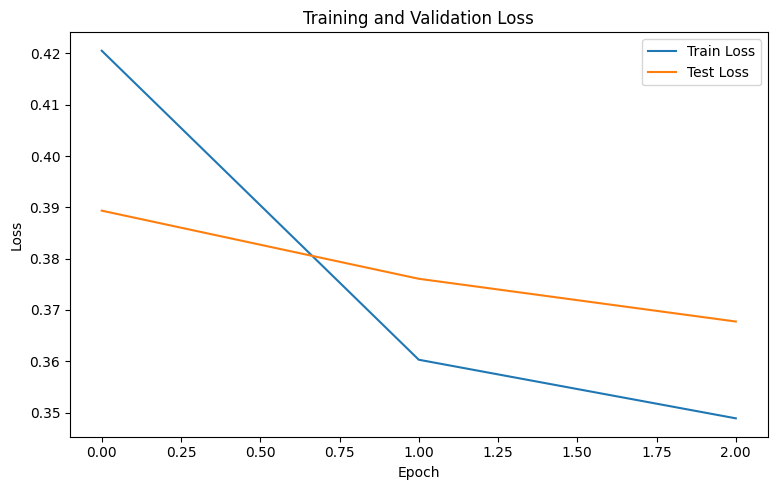

In [193]:
plot_losses(train_losses, test_losses)

In [156]:
model = ImageCaptionModel()
model.load_state_dict(torch.load("/kaggle/working/modelo_treinado.pth", map_location=device))
model.to(device)


ImageCaptionModel(
  (encoder): Encoder(
    (features): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(256, eps

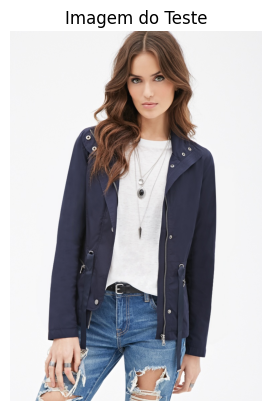

Legenda real:     This lady is wearing a long-sleeve sweater with solid color patterns. The sweater is with cotton fabric and its neckline is round. The outer clothing is with cotton fabric and solid color patterns. The lady is wearing a belt. There is an accessory in his her neck. The person wears a ring.
Legenda gerada:   The female is wearing a long-sleeve sweater with pure color patterns and a long pants. The sweater is with cotton fabric and its neckline is


In [157]:
# Pegando uma amostra do test_loader
batch = next(iter(test_loader))
image_tensor = batch["image_tensor"][0]
caption_real = batch["caption"][0]
image_pil = batch["image_original"][0]

# Tokenizer padrão GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Gerar legenda
caption_pred = generate_caption(model, image_tensor, tokenizer, device=device)

# Mostrar resultado
plt.imshow(image_pil)
plt.axis("off")
plt.title("Imagem do Teste")
plt.show()

print(f"Legenda real:     {caption_real}")
print(f"Legenda gerada:   {caption_pred}")


# Discussão Geral